In [2]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as dataF
import os
import time
import pickle
import numpy as np
from PIL import Image
import re
import io

import json
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

True

In [3]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

### Bar to visualize progress

In [4]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# IMAGES
im_path_fur = '../images/v2/full'

# ONEHOTS
onehots_vocab_p = '../json_files/ADARI_furniture_onehots_vocab.json'
onehots_w2i_p = '../json_files/ADARI_furniture_onehots_w2i.json'
onehots_i2w_p = '../json_files/ADARI_furniture_onehots_i2w.json'
onehots_p = '../json_files/ADARI_furniture_onehots.json'

# FILES FOR DATALOADER
# dset_words_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_words.json"
# vocab_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_vocab_adjs.json"

In [6]:
# Open json files with embeddings 
onehots = open_json(onehots_p)
onehots_vocab = open_json(onehots_vocab_p)
onehots_w2i = open_json(onehots_w2i_p)
onehots_i2w = open_json(onehots_i2w_p)

### Split dataset into train, validation and test

In [7]:
import random

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)
    return d

def splitDict(d_img_words, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    d_img_words = shuffle_dict(d_img_words)
    
    im_words = iter(d_img_words.items())      
    
    # Image - words
    dtrain_imw = dict(itertools.islice(im_words, train_n))  
    dtest_imw = dict(itertools.islice(im_words, test_n))   
    dval_imw = dict(itertools.islice(im_words, val_n))
    
    
    print('trainset size: ', len(dtrain_imw), 'test dataset size: ',len(dtest_imw), 'val set size: ', len(dval_imw))
    return dtrain_imw, dtest_imw, dval_imw 

In [8]:
dtrain_w, dtest_w, dval_w = splitDict(onehots, .8, 1000)

trainset size:  13225 dataset size:  3307 val set size:  1000


In [9]:
class MyDataset(Dataset):
    def __init__(self, onehots, w2i, i2w, image_path):
        self.onehots_d = onehots
        self.w2i = w2i
        self.i2w = i2w
        self.images_names = list(self.onehots_d.keys()) # names
        self.onehots = list(self.onehots_d.values()) # onehots
        self.image_path = image_path
    
    def __len__(self):
        return len(self.onehots)
    
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img

    def __getitem__(self, index):
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)
        onehot = torch.FloatTensor(self.onehots[index])
        
        return img, onehot

In [10]:
dataset_train = MyDataset(dtrain_w, onehots_w2i, onehots_i2w, im_path_fur)
dataset_test = MyDataset(dtest_w, onehots_w2i, onehots_i2w,im_path_fur)
dataset_val = MyDataset(dval_w, onehots_w2i, onehots_i2w,  im_path_fur)

In [11]:
batch_size = 64
num_workers = 8 if cuda else 0

In [14]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)


In [36]:
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

In [15]:
# to test dataloader
it = iter(test_dataloader)
print(next(it))


[tensor([[[[0.8863, 0.8902, 0.8980,  ..., 0.8784, 0.8706, 0.8667],
          [0.8902, 0.8941, 0.8980,  ..., 0.8784, 0.8745, 0.8706],
          [0.8902, 0.8980, 0.9020,  ..., 0.8824, 0.8784, 0.8745],
          ...,
          [0.6314, 0.6471, 0.6667,  ..., 0.6196, 0.6314, 0.6431],
          [0.6157, 0.6431, 0.6588,  ..., 0.6078, 0.6275, 0.6275],
          [0.5922, 0.6196, 0.6431,  ..., 0.6196, 0.6039, 0.6000]],

         [[0.8863, 0.8902, 0.8980,  ..., 0.8784, 0.8706, 0.8667],
          [0.8902, 0.8941, 0.8980,  ..., 0.8784, 0.8745, 0.8706],
          [0.8902, 0.8980, 0.9020,  ..., 0.8824, 0.8784, 0.8745],
          ...,
          [0.6118, 0.6314, 0.6510,  ..., 0.5961, 0.6078, 0.6196],
          [0.5961, 0.6235, 0.6392,  ..., 0.5882, 0.5961, 0.5922],
          [0.5725, 0.5961, 0.6157,  ..., 0.5961, 0.5765, 0.5725]],

         [[0.8863, 0.8902, 0.8980,  ..., 0.8784, 0.8706, 0.8667],
          [0.8902, 0.8941, 0.8980,  ..., 0.8784, 0.8745, 0.8706],
          [0.8902, 0.8980, 0.9020,  ..., 

### Image embedding

In [16]:
feature_extract = False # so we update the whole model 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    
    return model_ft, input_size


In [18]:
num_classes = len(onehots_w2i)
model, input_size = initialize_model(num_classes, feature_extract)
model.fc.weight.shape
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, label_ranking_average_precision_score
from torch.optim import lr_scheduler

device = torch.device("cuda" if cuda else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005)
plateau = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [20]:
def train_epoch(model, loader, optimizer, criterion, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    result = []
    
    start_time = time.time()
    for batch_idx, (image, target) in enumerate(loader):   
        image = image.to(device)
        target = target.to(device)
        output = model(image)
        loss = criterion(output, target) # Averaging losses from all vector components. 

        # We use sigmoid for prediction. Sigmoid is applied to each individual class in the 2700 classes. 
        # Therefore, if it's more than 0.5, we predict it as True. 
        preds = torch.sigmoid(output).data > 0.5
        preds = preds.to(torch.float32)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()   
        
        running_loss += loss.item() * image.shape[0]
        
        # Metrics 
        f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
        precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
        accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)

        running_corrects += f1
        running_precision += precision
        running_accuracy += accuracy

    end_time = time.time()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    
    result.append('Training Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision))
    print(result)
    return epoch_loss, epoch_f1

In [21]:
def test_epoch(model, loader, criterion):
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0

    result = []
    with torch.no_grad():
        for batch_idx, (image, target) in enumerate(loader):   
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            loss = criterion(output, target)

            preds = torch.sigmoid(output).data > 0.5
            preds = preds.to(torch.float32)

            running_loss += loss.item() * image.shape[0]
            
            # Metrics 
            f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)

            running_corrects += f1
            running_precision += precision
            running_accuracy += accuracy
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    
    result.append('Testing Loss: {:.4f} F1: {:.4f} Acc: {:.4f} Prec: {:.4f}'.format(epoch_loss, epoch_f1, epoch_acc, epoch_precision))
    print(result)
    return epoch_loss, epoch_f1

In [22]:
len(train_dataloader.dataset), len(test_dataloader.dataset)

(13225, 3307)

In [23]:
def createCheckpoint(filename, batch_size):
    checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
    } # save all important stuff
    torch.save(checkpoint , filename)

In [25]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

save_model_path = './saved_models/multilabel_adam0.003_plateau/'
epochs=50
best_loss = 1000.0
for i in range(epochs):
    print('-----Training epoch {}/{} --------'.format(i,epochs-1))
    tr_loss, tr_acc = train_epoch(model, train_dataloader, optimizer, criterion, sgdr_partial)
    print('train epoch: {}, loss: {}'.format(i, tr_loss))
    print()
    print('------Testing epoch {}/{} --------'.format(i,epochs-1))
    tst_loss, tst_acc = test_epoch(model, test_dataloader, criterion)
    print('test epoch: {}, loss: {}'.format(i, tst_loss))
#     plateau.step(tst_loss)
    
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    test_losses.append(tst_loss)
    test_accs.append(tst_acc)
    
    if tst_loss < best_loss:
        best_loss = tst_loss
        save_path_resnet = save_model_path + 'resnet_{}.pt'.format(i)
        createCheckpoint(save_path_resnet, 64)
    

-----Training epoch 0/49 --------
['Training Loss: 0.0143 F1: 0.0118 Acc: 0.0000 Prec: 0.0644']
train epoch: 0, loss: 0.014297237147511967

------Testing epoch 0/49 --------
['Testing Loss: 0.0147 F1: 0.0067 Acc: 0.0000 Prec: 0.0366']
test epoch: 0, loss: 0.014731252187762172
-----Training epoch 1/49 --------
['Training Loss: 0.0143 F1: 0.0116 Acc: 0.0000 Prec: 0.0623']
train epoch: 1, loss: 0.014271464961843252

------Testing epoch 1/49 --------
['Testing Loss: 0.0149 F1: 0.0016 Acc: 0.0000 Prec: 0.0091']
test epoch: 1, loss: 0.014937982552591628
-----Training epoch 2/49 --------
['Training Loss: 0.0142 F1: 0.0141 Acc: 0.0000 Prec: 0.0749']
train epoch: 2, loss: 0.014248153415556103

------Testing epoch 2/49 --------
['Testing Loss: 0.0148 F1: 0.0093 Acc: 0.0000 Prec: 0.0496']
test epoch: 2, loss: 0.014758153236435914
-----Training epoch 3/49 --------
['Training Loss: 0.0142 F1: 0.0164 Acc: 0.0000 Prec: 0.0862']
train epoch: 3, loss: 0.014203182926193754

------Testing epoch 3/49 ----

In [26]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short):
    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.show()

In [33]:
epochs_list = [e for e in range(epochs)]

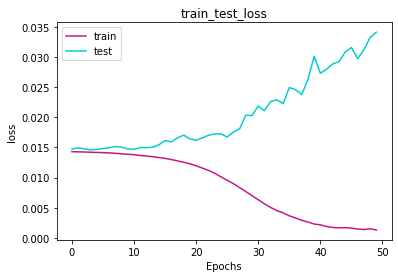

In [35]:
make_graph(epochs_list, train_losses, test_losses, 'train', 'test', 'train_test_loss', 'loss')

### INFERENCE

In [52]:
def evaluate(model, loader, threshold):
    model.eval()
    model.to(device)
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_lraps = 0.0
    
    with torch.no_grad():
        for batch_idx, (image, target) in enumerate(loader):   
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            preds = torch.sigmoid(output).data > threshold
            preds = preds.to(torch.float32)

            # Metrics 
            f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*image.size(0)
            accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)
            lraps = label_ranking_average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*image.size(0)
            
            running_corrects += f1
            running_precision += precision
            running_accuracy += accuracy
            running_lraps += lraps
        
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_precision = running_precision / len(loader.dataset)
    epoch_acc = running_accuracy / len(loader.dataset)
    epoch_lraps = running_lraps / len(loader.dataset)
    
    result = 'T: {} Evaluate F1: {:.4f} Acc: {:.4f} Prec: {:.4f} LRAPS: {:.4f}'.format(threshold, epoch_f1, epoch_acc, epoch_precision, epoch_lraps)
    print(result)
    #return epoch_loss, epoch_f1

In [53]:
import warnings
warnings.filterwarnings(action='ignore')
for t in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    evaluate(model, val_dataloader, t)

T: 0.1 Evaluate F1: 0.2034 Acc: 0.0000 Prec: 0.1813 LRAPS: 0.0744
T: 0.2 Evaluate F1: 0.1945 Acc: 0.0010 Prec: 0.2024 LRAPS: 0.0719
T: 0.3 Evaluate F1: 0.1839 Acc: 0.0030 Prec: 0.2181 LRAPS: 0.0695
T: 0.4 Evaluate F1: 0.1742 Acc: 0.0030 Prec: 0.2287 LRAPS: 0.0682
T: 0.5 Evaluate F1: 0.1615 Acc: 0.0020 Prec: 0.2377 LRAPS: 0.0647
T: 0.6 Evaluate F1: 0.1456 Acc: 0.0020 Prec: 0.2417 LRAPS: 0.0602
T: 0.7 Evaluate F1: 0.1309 Acc: 0.0020 Prec: 0.2472 LRAPS: 0.0565
T: 0.8 Evaluate F1: 0.1147 Acc: 0.0020 Prec: 0.2484 LRAPS: 0.0529
T: 0.9 Evaluate F1: 0.0896 Acc: 0.0010 Prec: 0.2346 LRAPS: 0.0450


### Show predictions 

In [56]:
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [105]:
from torchvision.transforms import ToPILImage

def idx2word_(vector):
    labels = []
    vector = vector.squeeze(0)
    idxs = vector.nonzero()
    idxs = idxs[0].tolist()
    for idx in idxs:
        labels.append(onehots_i2w[str(idx)])
    return labels

def show_predicted(model, loader, threshold):
    model.eval()
    model.to(device)
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_lraps = 0.0
    
    with torch.no_grad():
        for batch_idx, (image, target) in enumerate(loader):   
            if batch_idx == 50:
                break
            image = image.to(device)
            target = target.to(device)
            
            output = model(image)
            preds = torch.sigmoid(output).data > threshold

            gt_labels = idx2word_(target.detach().cpu().numpy())
            pred_labels = idx2word_(preds.detach().cpu().numpy())
            
            # image 
            ima = ToPILImage()(image.detach().cpu().squeeze(0)) 
            plt.imshow(ima)
            plt.show()
            
            print('ground truth labels: ')
            print(gt_labels)
            print('pred labels: ')
            print(pred_labels)
            


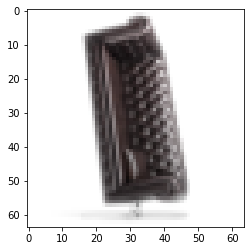

ground truth labels: 
['low', 'light', 'british', 'iconic', 'black', 'upholstered', 'colourful', 'reminiscent', 'square', 'slender']
pred labels: 
['small', 'light', 'swedish', 'black', 'special', 'italian']


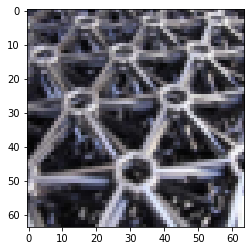

ground truth labels: 
['simple', 'different', 'recycled', 'original', 'dutch', 'special', 'industrial', 'plastic', 'hard', 'basic']
pred labels: 
['different', 'flat']


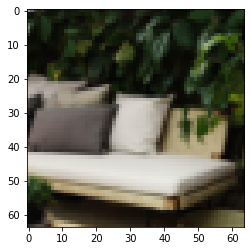

ground truth labels: 
['small', 'low', 'different', 'natural', 'swedish', 'great', 'special', 'thin', 'flat', 'large']
pred labels: 
['modern', 'contemporary', 'different', 'traditional']


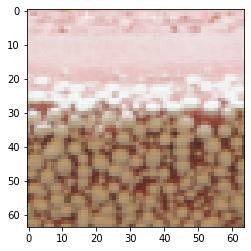

ground truth labels: 
['different', 'white', 'giant', 'oversized', 'sweet', 'transparent', 'good', 'artificial', 'synthetic', 'obvious']
pred labels: 
['different', 'wooden', 'special', 'white', 'large', 'lightweight']


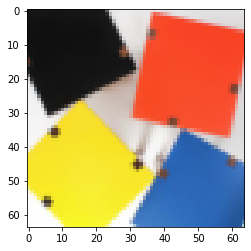

ground truth labels: 
['old', 'different', 'red', 'solid', 'dutch', 'black', 'american', 'blue', 'geometric', 'full']
pred labels: 
['old', 'red', 'yellow', 'local', 'solid', 'dutch', 'black', 'white', 'blue', 'asymmetrical']


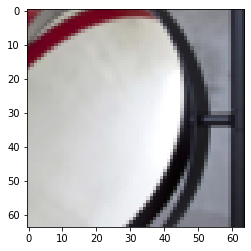

ground truth labels: 
['small', 'circular', 'different', 'red', 'modular', 'natural', 'solid', 'white', 'italian', 'open']
pred labels: 
['different', 'light', 'natural']


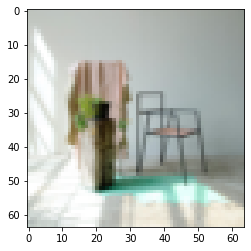

ground truth labels: 
['simple', 'small', 'light', 'solid', 'blue', 'minimal', 'industrial', 'long', 'large', 'big']
pred labels: 
['small', 'wooden', 'italian', 'long', 'single', 'large']


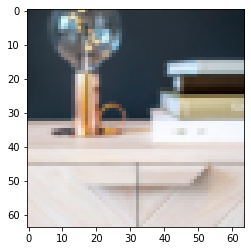

ground truth labels: 
['simple', 'different', 'wooden', 'traditional', 'sustainable', 'unique', 'flat', 'industrial', 'open', 'geometric']
pred labels: 
['different', 'british', 'solid', 'flat', 'italian', 'single', 'large']


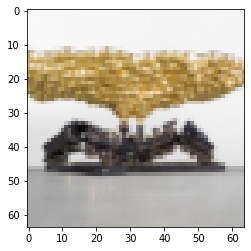

ground truth labels: 
['front', 'small', 'sculptural', 'black', 'american', 'future', 'creative', 'polished', 'large', 'open']
pred labels: 
['small', 'young', 'coloured', 'lightweight']


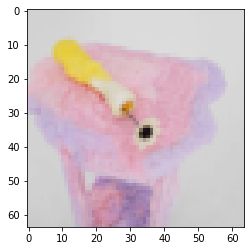

ground truth labels: 
['natural', 'original', 'chinese', 'human', 'interesting', 'coloured', 'organic', 'long', 'geometric', 'tactile']
pred labels: 
['simple', 'different', 'natural', 'original', 'industrial', 'long', 'large']


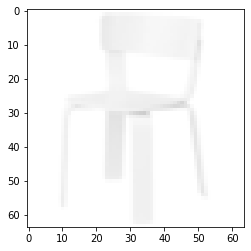

ground truth labels: 
['modern', 'small', 'international', 'digital', 'original', 'swedish', 'black', 'japanese', 'wide', 'big']
pred labels: 
['versatile', 'swedish', 'top', 'thin', 'tubular']


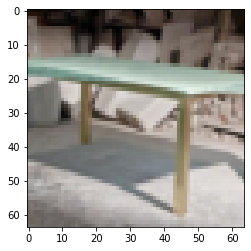

ground truth labels: 
['contemporary', 'different', 'beautiful', 'functional', 'unique', 'reminiscent', 'belgian', 'green', 'triangular', 'hot']
pred labels: 
['modern', 'curved', 'british']


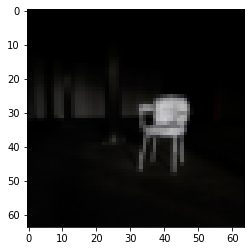

ground truth labels: 
['soft', 'dutch', 'hand-stitched', 'second-hand']
pred labels: 
['different', 'soft', 'dutch', 'blue', 'wide']


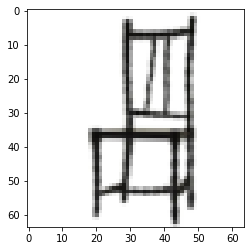

ground truth labels: 
['different', 'interior', 'natural', 'local', 'dutch', 'black', 'special', 'white', 'unique', 'architectural']
pred labels: 
[]


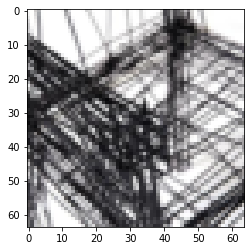

ground truth labels: 
['simple', 'different', 'strong', 'solid', 'human', 'interesting', 'thin', 'single', 'basic', 'standard']
pred labels: 
['individual', 'wide', 'open']


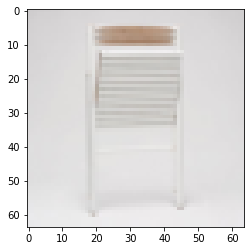

ground truth labels: 
['simple', 'old', 'different', 'wooden', 'yellow', 'natural', 'original', 'dutch', 'everyday', 'white']
pred labels: 
['small', 'vertical', 'unusual']


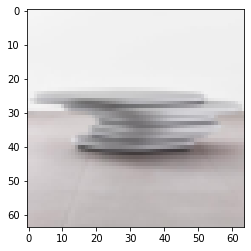

ground truth labels: 
['simple', 'different', 'strong', 'soft', 'functional', 'traditional', 'sculptural', 'original', 'classic', 'innovative']
pred labels: 
['different', 'modular', 'functional', 'flat', 'large']


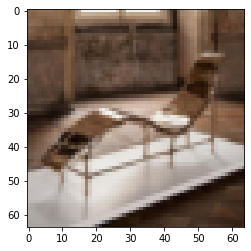

ground truth labels: 
['old', 'back', 'digital', 'original', 'sustainable', 'dutch', 'thin', 'large', 'green', 'ancient']
pred labels: 
['different', 'outdoor', 'natural', 'curved', 'traditional', 'sustainable']


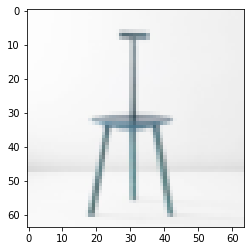

ground truth labels: 
['natural', 'prestigious', 'innovative', 'delicate', 'optical', 'outstanding', 'eponymous', 'iridescent', 'super', 'intelligent']
pred labels: 
['modern', 'old', 'different', 'traditional', 'tubular', 'large']


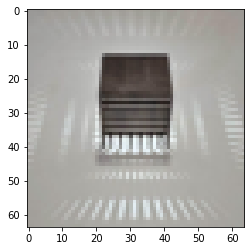

ground truth labels: 
['practical', 'small', 'different', 'subtle', 'beautiful', 'original', 'dutch', 'formal', 'nice', 'tiny']
pred labels: 
['circular', 'young', 'danish', 'industrial']


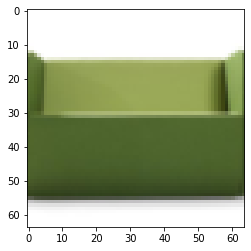

ground truth labels: 
['contemporary', 'simple', 'wooden', 'high', 'light', 'traditional', 'dutch', 'single', 'basic', 'bent']
pred labels: 
['simple', 'circular', 'wooden', 'high', 'curved', 'traditional', 'dutch', 'black', 'danish', 'single', 'large']


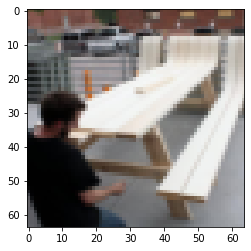

ground truth labels: 
['contemporary', 'front', 'common', 'functional', 'public', 'american', 'open', 'temporary', 'permanent', 'standard']
pred labels: 
['contemporary', 'different', 'british', 'coloured', 'single', 'spanish']


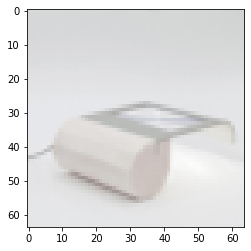

ground truth labels: 
['modern', 'contemporary', 'simple', 'old', 'small', 'natural', 'common', 'functional', 'creative', 'domestic']
pred labels: 
['simple', 'small', 'different', 'large']


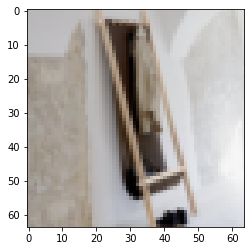

ground truth labels: 
['mutual', 'strong', 'elegant', 'german', 'stable', 'consistent', 'loose']
pred labels: 
['small', 'different', 'flat', 'long', 'unusual', 'full']


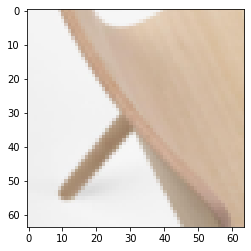

ground truth labels: 
['simple', 'low', 'wooden', 'british', 'local', 'iconic', 'long', 'round', 'open', 'lightweight']
pred labels: 
['simple', 'wooden', 'light', 'natural', 'curved', 'solid', 'black', 'industrial']


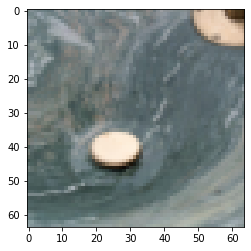

ground truth labels: 
['different', 'strong', 'original', 'public', 'black', 'white', 'unique', 'italian', 'wide', 'green']
pred labels: 
['simple', 'circular', 'industrial', 'single', 'open', 'geometric']


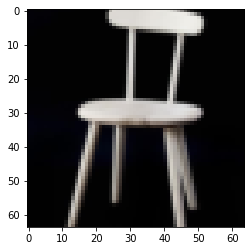

ground truth labels: 
['outdoor', 'english', 'traditional', 'deep', 'original', 'great', 'special', 'fine', 'ready', 'green']
pred labels: 
['outdoor', 'english', 'traditional', 'deep', 'original', 'great', 'special', 'fine', 'ready', 'green']


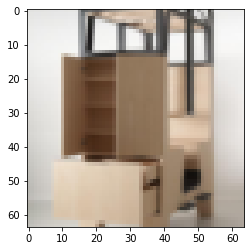

ground truth labels: 
['old', 'small', 'modular', 'interior', 'intimate', 'dutch', 'well', 'fine', 'reminiscent', 'architectural']
pred labels: 
['wooden', 'strong', 'solid', 'raw', 'black']


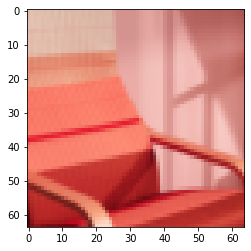

ground truth labels: 
['different', 'modular', 'bright', 'soft', 'swedish', 'dutch', 'creative', 'blue', 'colourful', 'geometric']
pred labels: 
['different', 'red', 'wooden', 'high', 'upholstered', 'rounded']


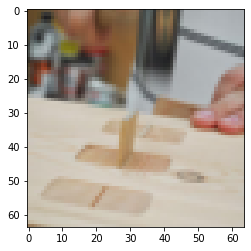

ground truth labels: 
['durable', 'italian', 'milan-based']
pred labels: 
['small', 'different', 'wooden', 'light', 'traditional', 'local', 'large']


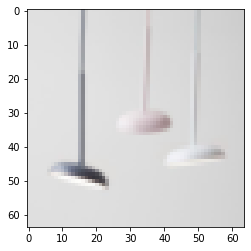

ground truth labels: 
['contemporary', 'young', 'strong', 'stackable', 'solid', 'minimal', 'geometric', 'due', 'scandinavian', 'norwegian']
pred labels: 
['low', 'different', 'traditional', 'white', 'wide']


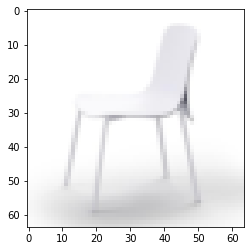

ground truth labels: 
['contemporary', 'simple', 'small', 'different', 'modular', 'light', 'natural', 'black', 'white', 'japanese']
pred labels: 
['low', 'tubular', 'large', 'japanese', 'standard']


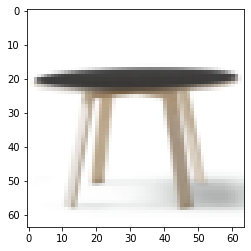

ground truth labels: 
['red', 'wooden', 'high', 'natural', 'british', 'solid', 'black', 'white', 'italian', 'round']
pred labels: 
['visual', 'italian']


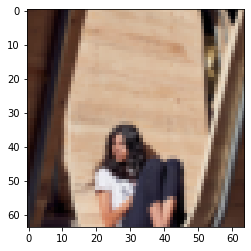

ground truth labels: 
['small', 'outdoor', 'british', 'undulating', 'public', 'central', 'single', 'large', 'giant', 'communal']
pred labels: 
['modern', 'wooden', 'strong', 'natural', 'functional', 'original', 'creative', 'single']


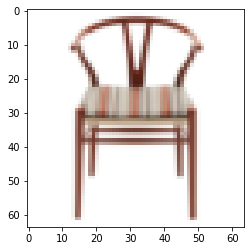

ground truth labels: 
['contemporary', 'different', 'wooden', 'british', 'creative', 'danish', 'blue', 'large', 'green', 'big']
pred labels: 
['low', 'different', 'wooden', 'light', 'british', 'long', 'single']


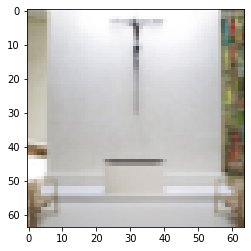

ground truth labels: 
['contemporary', 'simple', 'small', 'different', 'original', 'black', 'creative', 'french', 'flat', 'large']
pred labels: 
['traditional', 'norwegian']


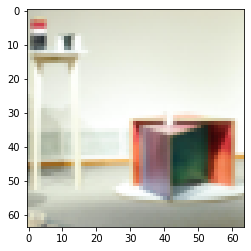

ground truth labels: 
['contemporary', 'old', 'different', 'wooden', 'natural', 'curved', 'traditional', 'local', 'industrial', 'large']
pred labels: 
['different', 'traditional', 'large', 'open']


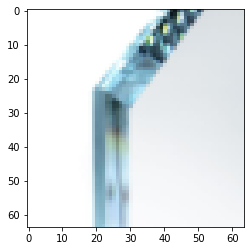

ground truth labels: 
['light', 'thick', 'rectangular', 'italian', 'reflective', 'japanese', 'shimmering']
pred labels: 
['simple', 'high', 'industrial', 'single']


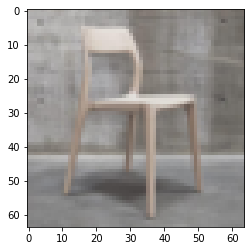

ground truth labels: 
['low', 'wooden', 'interior', 'soft', 'sculptural', 'swedish', 'great', 'comfortable', 'industrial', 'long']
pred labels: 
['contemporary', 'wooden', 'young', 'natural', 'british', 'dutch', 'large', 'lightweight']


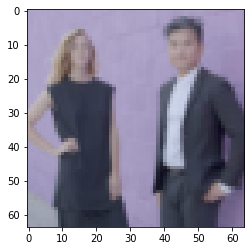

ground truth labels: 
['contemporary', 'small', 'different', 'playful', 'central', 'individual', 'single', 'wide', 'multiple', 'architectural']
pred labels: 
['dutch', 'free', 'japanese']


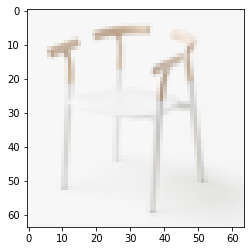

ground truth labels: 
['low', 'different', 'wooden', 'high', 'white', 'italian', 'minimal', 'japanese', 'interchangeable', 'artificial']
pred labels: 
['low', 'different', 'wooden', 'high', 'white', 'minimal', 'japanese', 'interchangeable', 'artificial']


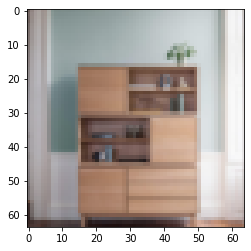

ground truth labels: 
['small', 'modular', 'curved', 'functional', 'original', 'solid', 'black', 'upholstered', 'white', 'green']
pred labels: 
['small', 'raw', 'domestic', 'colourful']


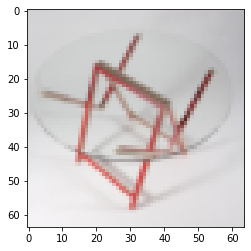

ground truth labels: 
['wooden', 'solid', 'efficient', 'central', 'french', 'long', 'round', 'upper', 'obvious', 'colored']
pred labels: 
['different', 'long', 'large']


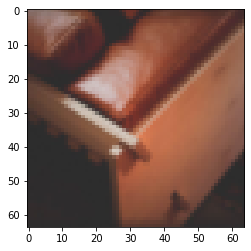

ground truth labels: 
['simple', 'red', 'bright', 'young', 'common', 'great', 'little', 'long', 'single', 'architectural']
pred labels: 
['simple', 'different', 'wooden', 'british', 'traditional', 'white']


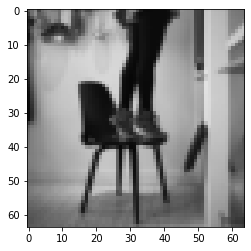

ground truth labels: 
['contemporary', 'simple', 'different', 'high', 'light', 'danish', 'upholstered', 'unique', 'long', 'single']
pred labels: 
['young', 'top']


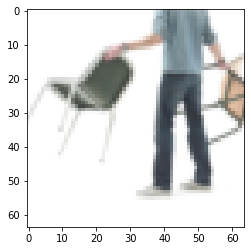

ground truth labels: 
['front', 'small', 'wooden', 'raw', 'tubular', 'lightweight', 'ultra-thin', 'lazy']
pred labels: 
['natural', 'rectangular']


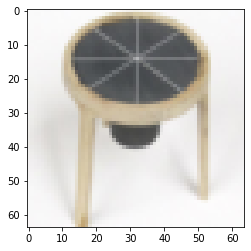

ground truth labels: 
['different', 'young', 'natural', 'sustainable', 'human', 'special', 'unique', 'industrial', 'long', 'big']
pred labels: 
['contemporary', 'young', 'natural', 'traditional', 'iconic', 'little']


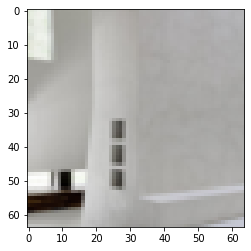

ground truth labels: 
['contemporary', 'simple', 'small', 'different', 'original', 'black', 'creative', 'french', 'flat', 'large']
pred labels: 
['simple', 'small', 'traditional', 'solid', 'black', 'white']


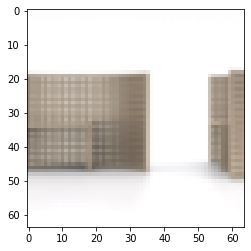

ground truth labels: 
['simple', 'wooden', 'young', 'complex', 'traditional', 'chinese', 'minimal', 'japanese', 'last', 'norwegian']
pred labels: 
['different', 'modular', 'solid', 'single', 'german']


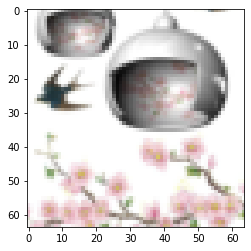

ground truth labels: 
['contemporary', 'different', 'modular', 'strong', 'dutch', 'creative', 'unique', 'large', 'japanese', 'big']
pred labels: 
['high', 'curved', 'black', 'white', 'unique', 'industrial']


In [106]:
show_predicted(model, val_dataloader, 0.5)